In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants import R_earth, R_sun
from batman import TransitParams, TransitModel
import astropy.units as u
import numpy as np

params = TransitParams()
params.per = 365.25
params.rp = float(R_earth/R_sun)
params.a = float(1*u.AU/R_sun)
params.inc = 89.9

# Sing 2009: https://arxiv.org/pdf/0912.2274.pdf
params.u = [0.45, 0.19]
params.limb_dark = "quadratic"

params.ecc = 0
params.w = np.pi/2
params.t0 = 0

In [114]:
virgo_times, virgo = np.load('inverted_psd.npy').T
virgo_times -= virgo_times.mean()


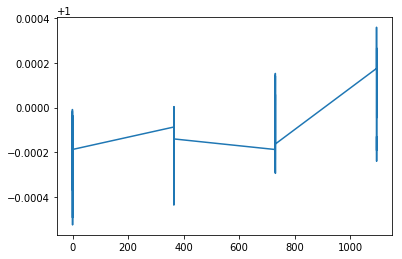

In [115]:
from scipy.interpolate import interp1d
t18, f18 = np.load('detrended_photometry2018.npy').T
t17, f17 = np.load('detrended_photometry2017.npy').T
t16, f16 = np.load('detrended_photometry2016.npy').T
t15, f15 = np.load('detrended_photometry2015.npy').T

times = np.concatenate([t15 / 60 / 60 / 24,
                        t16 / 60 / 60 / 24 + 365.25, 
                        t17 / 60 / 60 / 24 + 2*365.25, 
                        t18 / 60 / 60 / 24 + 3*365.25]) - (t15.mean() / 60 / 60 / 24)
fluxes = np.concatenate([f15, f16, f17, f18])
interp_virgo = interp1d(virgo_times, virgo)

fluxes += interp_virgo(times) + 1

m = TransitModel(params, times)
fluxes *= m.light_curve(params)
errors = np.ones_like(fluxes) * 1e-6
plt.plot(times, fluxes)

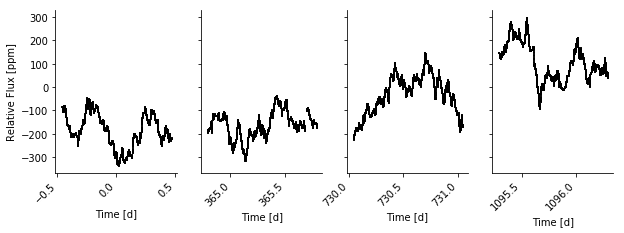

In [116]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharey=True)

splits = np.concatenate([[0], np.argwhere(np.diff(times) > 100).T[0], [len(times)]])

for i in range(4):
    ax[i].scatter(times[splits[i]+1:splits[i+1]], 
                  1e6*(interp_virgo(times)[splits[i]+1:splits[i+1]]), 
                  marker=',', s=1, alpha=1, color='k', rasterized=True)
    
    for s in ['right', 'top']:
        ax[i].spines[s].set_visible(False)
    ax[i].set_xlabel('Time [d]')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')
ax[0].set_ylabel('Relative Flux [ppm]')
plt.savefig('paper_plots/transits_psd_sample.png', bbox_inches='tight', dpi=250)

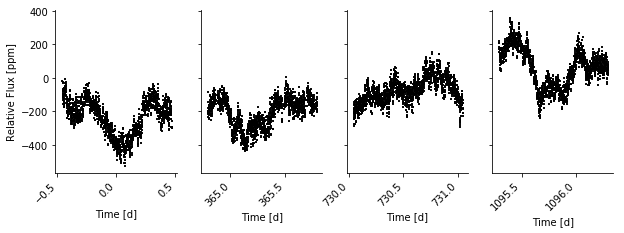

In [117]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharey=True)

splits = np.concatenate([[0], np.argwhere(np.diff(times) > 100).T[0], [len(times)]])

for i in range(4):
    ax[i].scatter(times[splits[i]+1:splits[i+1]], 
                  1e6*(fluxes[splits[i]+1:splits[i+1]] - 1), 
                  marker=',', s=1, alpha=1, color='k', rasterized=True)
    
    for s in ['right', 'top']:
        ax[i].spines[s].set_visible(False)
    ax[i].set_xlabel('Time [d]')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')
ax[0].set_ylabel('Relative Flux [ppm]')
fig.savefig('paper_plots/transits.pdf', bbox_inches='tight')

In [29]:
import emcee
import batman 
from copy import deepcopy
import celerite
from celerite import terms
from celerite.modeling import Model

class MeanModel(Model):
    parameter_names = 'rp, inc, a, t0, u1, u2'.split(', ')

    def get_value(self, t):
        trial_params = deepcopy(params)
        trial_params.rp = self.rp
        trial_params.inc = self.inc
        trial_params.t0 = self.t0
        trial_params.a = self.a
        trial_params.u = [self.u1, self.u2]

        m = batman.TransitModel(trial_params, t)
        return m.light_curve(trial_params)


m = batman.TransitModel(params, times)
transit_model = m.light_curve(params)

bounds = dict(log_S0=(-30, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=-24.5, log_omega0=4.17, log_Q=1/np.sqrt(2))
kernel.freeze_parameter('log_Q')

mean_model = mean=MeanModel(rp=params.rp, t0=params.t0, inc=params.inc, a=params.a,
                            u1=params.u[0], u2=params.u[1],  
                            bounds=dict(rp=(0, 1.2*float(R_earth/R_sun)), t0=(-0.01, 0.01), 
                                        u1=(-1, 1), u2=(-1, 1), inc=(0, 90), a=(100, 300)))

gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(times, yerr=errors)


def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(fluxes) + lp


nwalkers, ndim = 50, 8

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

initp = [np.array([-28, 7.3, params.rp, params.inc, params.a, params.t0, params.u[0], params.u[1]]) 
         + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]

print('burn in...')
p0 = sampler.run_mcmc(initp, 10000)[0]
sampler.reset()
print('production...')
sampler.run_mcmc(p0, 5000);

burn in...
production...


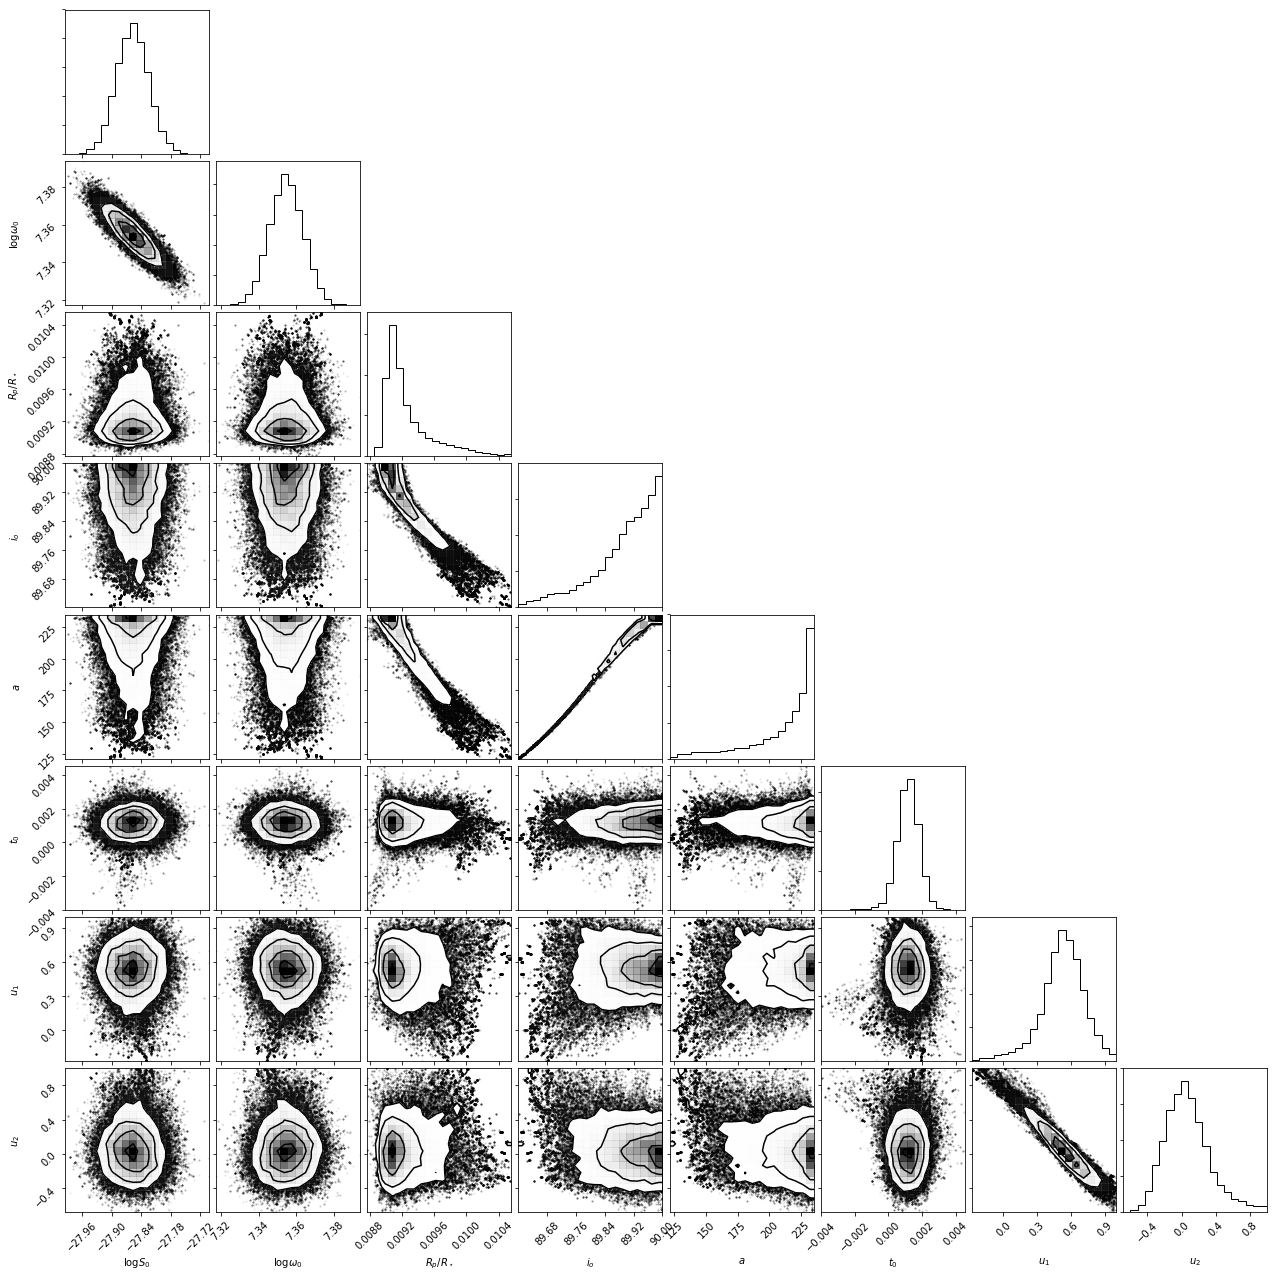

In [30]:
from corner import corner

corner(sampler.flatchain, labels=["${0}$".format(i) for i in "\log S_0,\log \omega_0,R_p/R_\star,i_o,a,t_0,u_1,u_2".split(',')]);
                                  #"\log a,\log c,\log P,R_p/R_\star,i_o,a,t_0,u_1,u_2".split(',')]);
plt.savefig("paper_plots/corner_oot.pdf", bbox_inches='tight')
plt.show()

0.032490072038091344

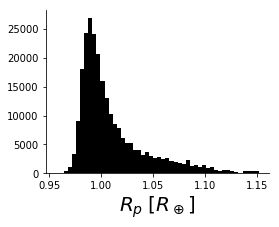

In [31]:
from astropy.constants import R_sun, R_earth

plt.figure(figsize=(4, 3))
plt.hist(sampler.flatchain[:, 2] / (R_earth/R_sun), bins=50, color='k', histtype='stepfilled')#, range=[0.8, 1.2]);
plt.xlabel("$R_p \; [R_\oplus]$", fontsize=20)
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.savefig('paper_plots/radius_posterior.pdf', bbox_inches='tight')
sampler.flatchain[:, 2].std() / sampler.flatchain[:, 2].mean()

(5.787571094726407, 0.05094699709872272)

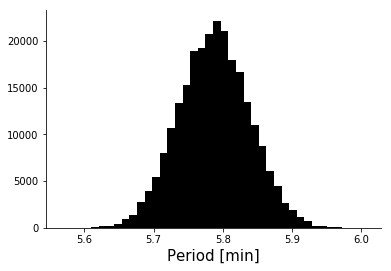

In [32]:
plt.hist(2*np.pi / np.exp(sampler.flatchain[:, 1]) * 24 * 60, bins=40, histtype='stepfilled', color='k')#, range=[5, 7])
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.xlabel('Period [min]', fontsize=15)
plt.savefig('paper_plots/oscillation_period.pdf', bbox_inches='tight')

(2*np.pi / np.exp(sampler.flatchain[:, 1]) * 24 * 60).mean(), (2*np.pi / np.exp(sampler.flatchain[:, 1]) * 24 * 60).std()